In [32]:
import pandas as pd
import time
import numpy as np
from sklearn.model_selection import GridSearchCV,train_test_split


from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline



from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier


from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix



np.random.seed(42)

# Deliverable 4
Alexandru Sauer (300026641,asaue046@uottawa.ca)
Jean-David Young (300011498,jyoun111@uottawa.ca)
Issam Robler (300014273,irobl078@uottawa.ca)



dataframe shape:
 (62, 40)
dataframe columns:
 Index(['country_id', 'country_year', 'country_code', 'country_name',
       'country_region', 'country_continent', 'country_currency',
       'country_capital', 'birth_rate_per_1000', 'human_capital_index',
       'labor_force', 'population_00_14', 'population_15_64',
       'population_65_up', 'population_growth_annual_percentage',
       'total_population', 'suicide_mortality_rate_per_100_000',
       'male_population', 'poverty_headcount_percentage_of_population',
       'female_population', 'health_id', 'health_year', 'health_country_code',
       'adults_15_plus_living_with_hiv',
       'capital_health_expenditure_percentage_gdp', 'death_rate_per_100_000',
       'diabetes_prevalence_percentage_population_age_20_to_79',
       'diarrhea_treatment_percentage_children_under_5',
       'hospital_beds_per_1000',
       'immunization_bcg_percentage_1_year_old_children',
       'immunization_dpt_percentage_12_to_23_month_children',
       '

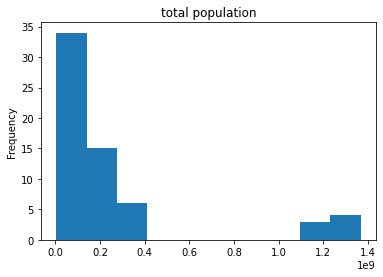

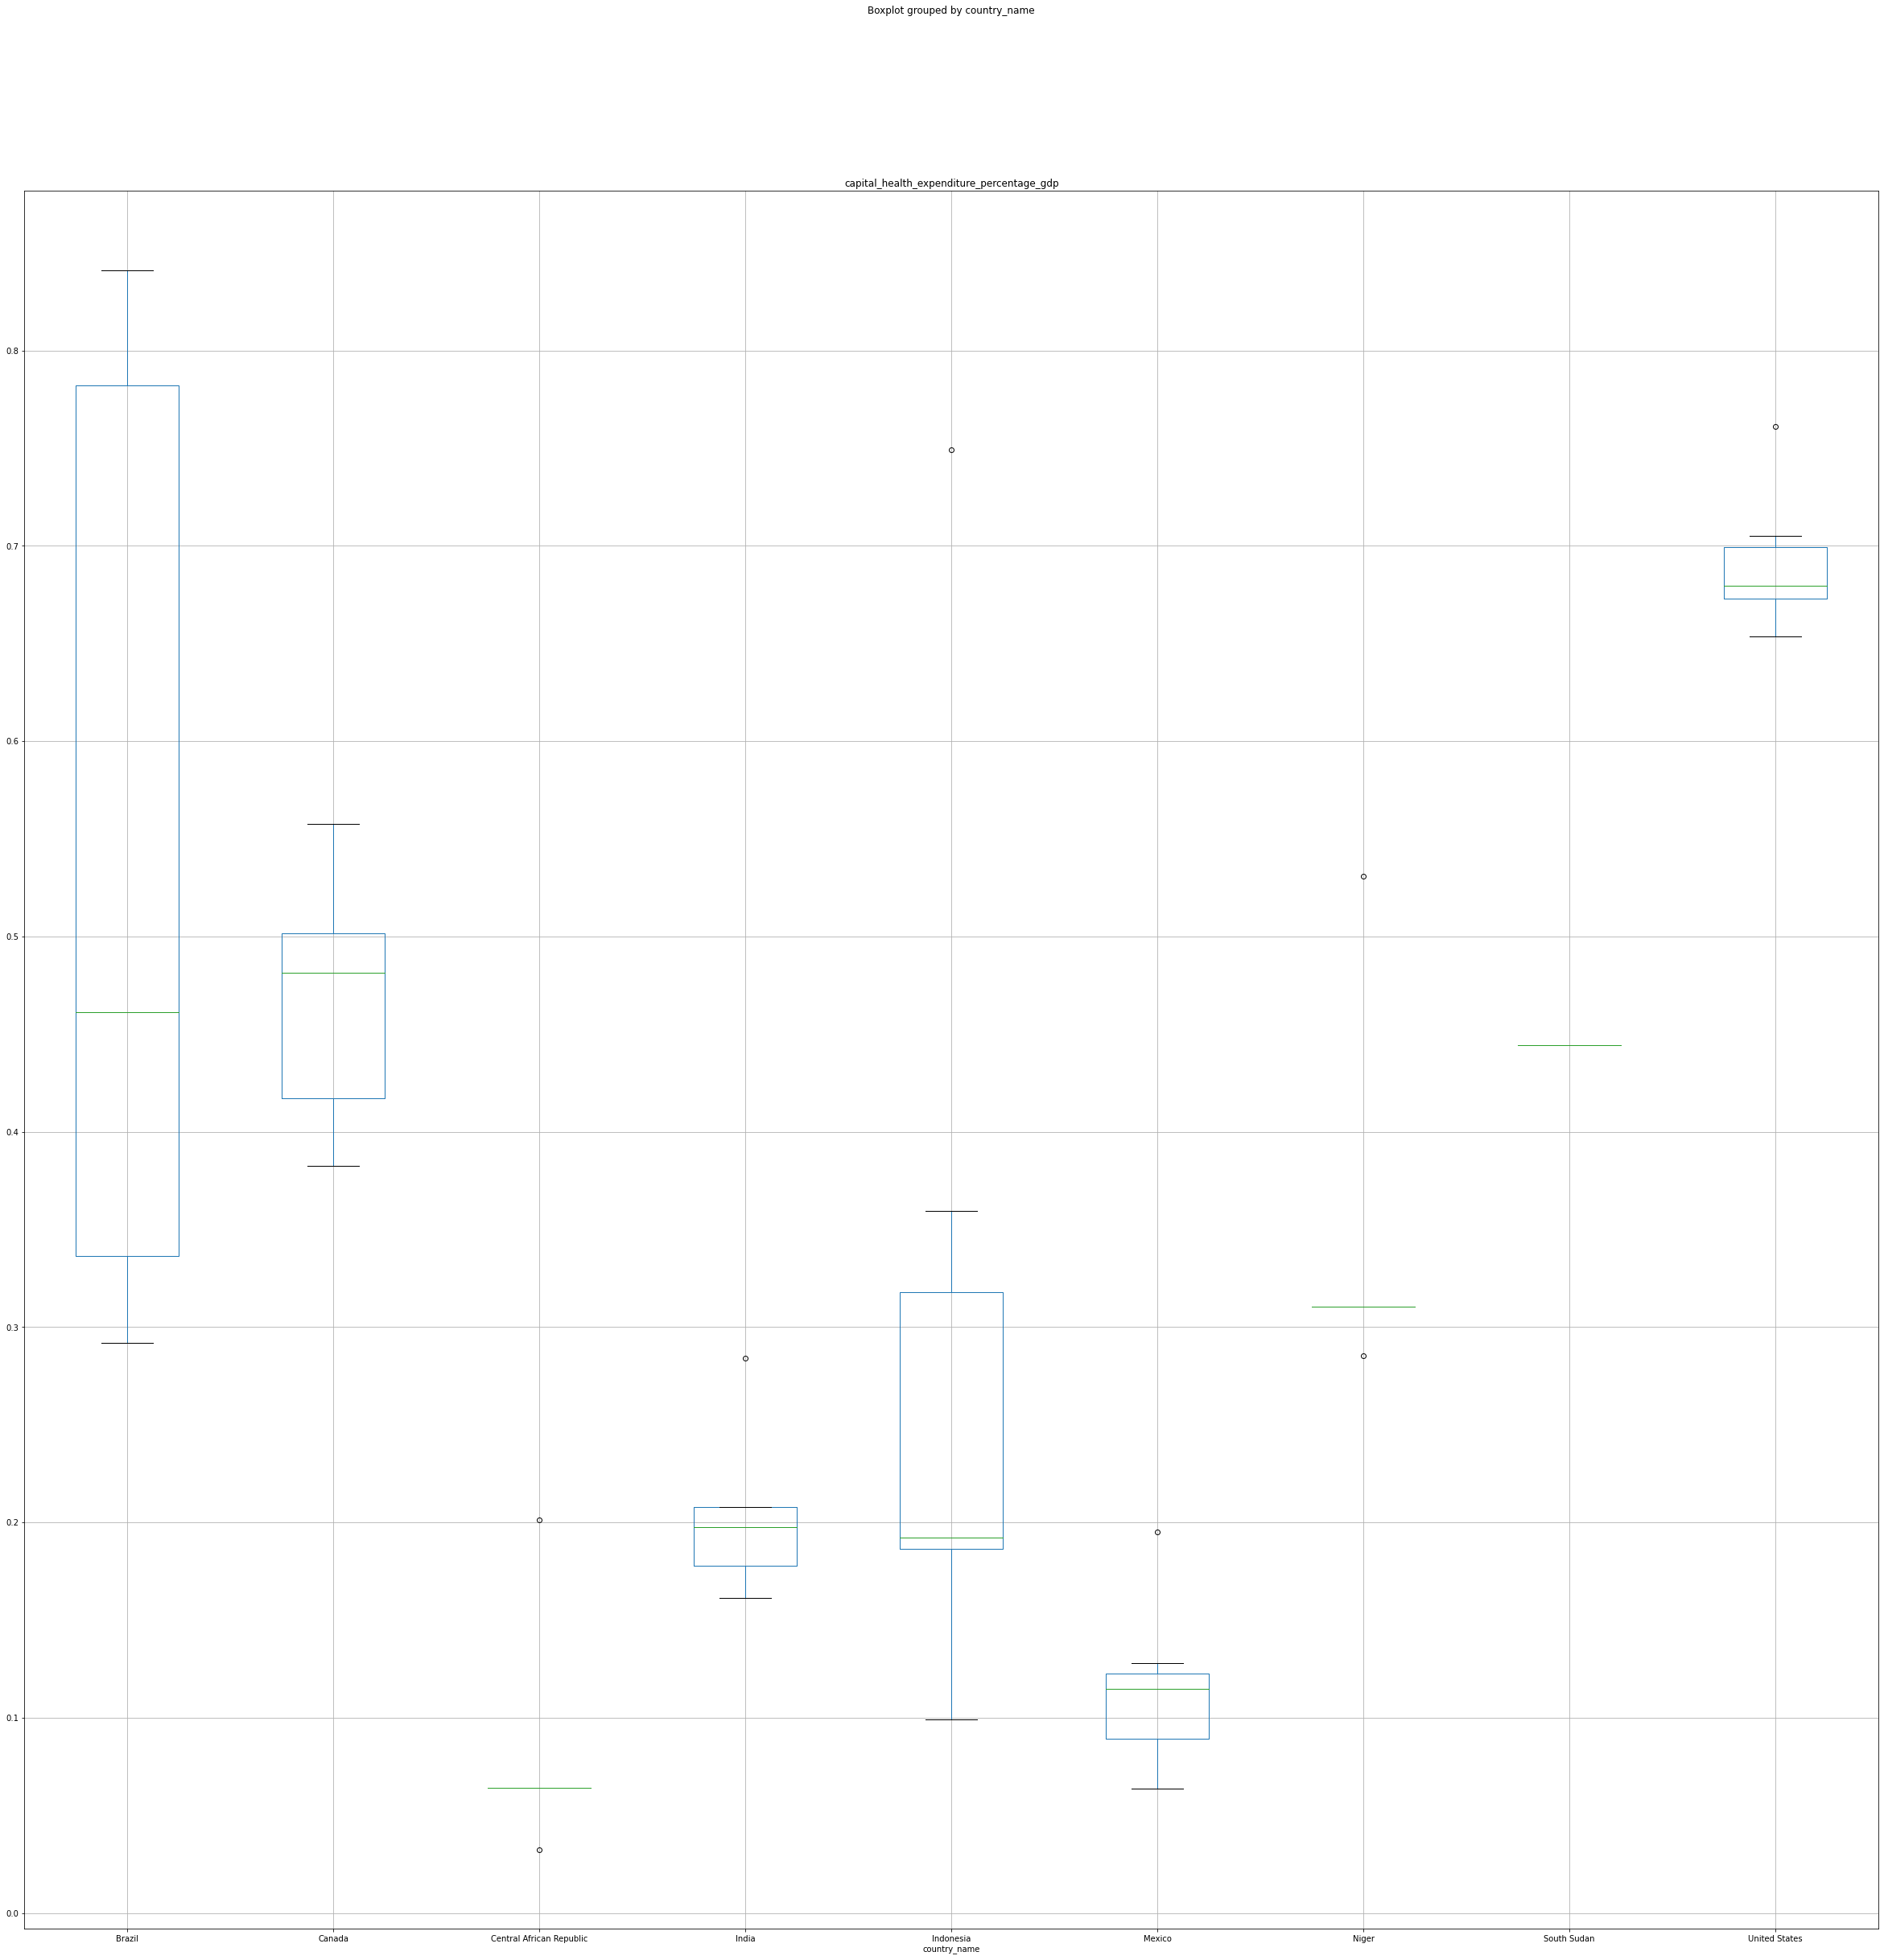

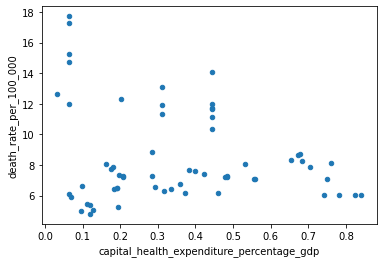

In [180]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

df = pd.read_csv('data_mining.csv')

print(f'dataframe shape:\n {df.shape}')


print(f'dataframe columns:\n {df.columns}')


print(f'dataframe info:\n {df.info()}')


print(f'Dataframe class distribution:\n {df["development_index"].value_counts()}')


total_population = df['total_population']
total_population.plot(kind='hist',title="total population")

health_expenditure = df[['country_name','capital_health_expenditure_percentage_gdp']]
health_expenditure.boxplot(column='capital_health_expenditure_percentage_gdp',by='country_name',figsize=(40,40))

death_rate_capital_health_expenditure = df[['death_rate_per_100_000','capital_health_expenditure_percentage_gdp']]
death_rate_capital_health_expenditure.plot(x='capital_health_expenditure_percentage_gdp',y='death_rate_per_100_000',kind='scatter')

cols = [
    "population_growth_annual_percentage",
    "total_population",
    "suicide_mortality_rate_per_100_000",
    "male_population",
    "poverty_headcount_percentage_of_population",
    "female_population",
    "adults_15_plus_living_with_hiv",
    "capital_health_expenditure_percentage_gdp",
    "death_rate_per_100_000",
    "diabetes_prevalence_percentage_population_age_20_to_79",
    "diarrhea_treatment_percentage_children_under_5",
    "hospital_beds_per_1000",
    "immunization_bcg_percentage_1_year_old_children",
    "immunization_dpt_percentage_12_to_23_month_children",
    "immunization_hib3_percentage_12_to_23_month_children",
    "immunization_hepb3_percentage_1_year_old_children",
    "immunization_measles_percentage_12_to_23_month_children",
    "incidence_of_hiv_per_1000_uninfected_population",
    "prevalence_of_overweight_percentage_of_adults",
    "prevalence_of_overweight_percentage_of_children_under_5",
    "prevalence_of_stunting_height_for_age_percentage_of_children_un",
    "prevalence_of_undernourishment_percentage_of_population"
]


X,y = df[cols],df["development_index"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,stratify=y)

### Fill missing values and standardize the attributes
num_pipeline = Pipeline([
    ('imputer',SimpleImputer(missing_values=-1.0,strategy='median')),
    ('std_scaler',StandardScaler())
])


X_train_prepared = num_pipeline.fit_transform(X_train)
X_test_prepared = num_pipeline.transform(X_test)

## Pick 10 best features based on chi2 function
y_train = y_train.to_numpy().reshape(-1,1)
y_test = y_test.to_numpy().reshape(-1,1)

ordEnc = OrdinalEncoder(categories=[['underdeveloped','developing','developed']])
y_train_prepared = ordEnc.fit_transform(y_train)
y_test_prepared = ordEnc.transform(y_test)

feature_selector = SelectKBest(score_func=f_classif,k=10)

X_train_prepared = feature_selector.fit_transform(X_train_prepared,y_train_prepared.ravel())
X_test_prepared = feature_selector.transform(X_test_prepared)






In [181]:

dt_model = DecisionTreeClassifier()


rf_model = RandomForestClassifier()

gb_model = GradientBoostingClassifier()


In [182]:


# parameters for DecisionTreeClassifier: 
    # max_depth ->  e.g., 3, 4
    # min_samples_split -> 5, 10
    # min_samples_leaf -> 10, 20
dt_params = [
    {'max_depth':[3,4],'min_samples_split':[5,10],'min_samples_leaf':[10,20]}
]

# parameters for RandomForestClassifier: 
    # n_estimators -> 100, 200
    # max_depth -> 3, 5
    # bootstrap -> True, False
rf_params = [
    {'n_estimators':[100,200],'max_depth':[3,5],'bootstrap':[True,False]}
]

gb_params = [
    {'n_estimators':[100,200],'max_depth':[3,5]}
]


# initialize gridsearch with the required parameters, including the following scoring methods and refit='bal_accuracy' (2)
scoring = {"accuracy": "accuracy", "bal_accuracy": "balanced_accuracy", "F1_macro": "f1_macro"}

grid_search_dt = GridSearchCV(dt_model,dt_params,scoring=scoring,cv=5,refit='bal_accuracy' ,return_train_score=True)
grid_search_rf = GridSearchCV(rf_model,rf_params,scoring=scoring,cv=5,refit='bal_accuracy' ,return_train_score=True)
grid_search_gb = GridSearchCV(gb_model,gb_params,scoring=scoring,cv=5,refit='bal_accuracy' ,return_train_score=True)

start = time.time()
grid_search_dt.fit(X_train_prepared,y_train_prepared.ravel())
stop = time.time()
print(f"Training time Decision Tree: {stop - start}s")


start = time.time()
grid_search_rf.fit(X_train_prepared,y_train_prepared.ravel())
stop = time.time()
print(f"Training time Random Forest: {stop - start}s")


start = time.time()
grid_search_gb.fit(X_train_prepared,y_train_prepared.ravel())
stop = time.time()
print(f"Training time Gradient Boosting: {stop - start}s")


print(f'Decision Tree best params:\n{grid_search_dt.best_params_}')
print(f'Random Forest best params:\n{grid_search_rf.best_params_}')
print(f'Gradient boosting best params:\n{grid_search_gb.best_params_}')

print(f'Decision Tree best estimator:\n{grid_search_dt.best_estimator_}')
print(f'Random Forest best estimator:\n{grid_search_rf.best_estimator_}')
print(f'Gradient boosting best estimator:\n{grid_search_gb.best_estimator_}')

print(f'Decision Tree best score:\n{grid_search_dt.best_score_}')
print(f'Random Forest best score:\n{grid_search_rf.best_score_}')
print(f'Gradient Boosting best score:\n{grid_search_gb.best_score_}')



Training time Decision Tree: 0.1484827995300293s
Training time Random Forest: 6.481713771820068s
Training time Gradient Boosting: 3.15348219871521s
Decision Tree best params:
{'max_depth': 4, 'min_samples_leaf': 10, 'min_samples_split': 5}
Random Forest best params:
{'bootstrap': True, 'max_depth': 5, 'n_estimators': 100}
Gradient boosting best params:
{'max_depth': 3, 'n_estimators': 100}
Decision Tree best estimator:
DecisionTreeClassifier(max_depth=4, min_samples_leaf=10, min_samples_split=5)
Random Forest best estimator:
RandomForestClassifier(max_depth=5)
Gradient boosting best estimator:
GradientBoostingClassifier()
Decision Tree best score:
0.861111111111111
Random Forest best score:
1.0
Gradient Boosting best score:
1.0


Why should you use cross-validation? 

The main reason one would want to do cross-validation is to test a ML algorithm's ability to handle new data. This can be used to check for overfitting.

In [183]:


final_prediction_dt = grid_search_dt.best_estimator_.predict(X_test_prepared)
final_prediction_rf = grid_search_rf.best_estimator_.predict(X_test_prepared)
final_prediction_gb = grid_search_gb.best_estimator_.predict(X_test_prepared)


conf_matrix_dt = confusion_matrix(y_test_prepared,final_prediction_dt)
class_report_dt  = classification_report(y_test_prepared,final_prediction_dt)
print(f'Classification report Decision Tree:\n {class_report_dt}')

conf_matrix_rf = confusion_matrix(y_test_prepared,final_prediction_rf)
class_report_rf = classification_report(y_test_prepared,final_prediction_rf)
print(f'Classification report Random Forest:\n {class_report_rf}')

conf_matrix_gb = confusion_matrix(y_test_prepared,final_prediction_gb)
class_report_gb  = classification_report(y_test_prepared,final_prediction_gb)
print(f'Classification report Gradient Boosting:\n {class_report_gb}')


Classification report Decision Tree:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         6
         1.0       1.00      0.70      0.82        10
         2.0       0.62      1.00      0.77         5

    accuracy                           0.86        21
   macro avg       0.88      0.90      0.86        21
weighted avg       0.91      0.86      0.86        21

Classification report Random Forest:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         6
         1.0       1.00      1.00      1.00        10
         2.0       1.00      1.00      1.00         5

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21

Classification report Gradient Boosting:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         6
         1.